In [0]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,classification_report,make_scorer,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split,GridSearchCV # Import train_test_split function

#for visualization
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.utils import resample

import warnings
warnings.simplefilter('ignore')


In [0]:
companyDf = pd.read_csv('../data/companies.csv')
acquisitionDf = pd.read_csv('../data/acquisitions.csv')
investmentDf = pd.read_csv('../data/investments.csv')
roundsDf = pd.read_csv('../data/rounds.csv')


In [3]:
companyDf.head()

permalink  ... last_funding_at
0                  /organization/-fame  ...      2015-01-05
1               /organization/-qounter  ...      2014-10-14
2  /organization/-the-one-of-them-inc-  ...      2014-01-30
3                /organization/0-6-com  ...      2008-03-19
4       /organization/004-technologies  ...      2014-07-24

[5 rows x 14 columns]

In [4]:
companyDf.rename({'permalink':'company_permalink', 'name':'company_name', 'category_list':'company_category_list','country_code':'company_country_code','state_code':'company_state_code','region':'company_region','city':'company_city'}, axis=1, inplace=True)
companyDf.head()

company_permalink  ... last_funding_at
0                  /organization/-fame  ...      2015-01-05
1               /organization/-qounter  ...      2014-10-14
2  /organization/-the-one-of-them-inc-  ...      2014-01-30
3                /organization/0-6-com  ...      2008-03-19
4       /organization/004-technologies  ...      2014-07-24

[5 rows x 14 columns]

In [5]:
companyDf['company_country_code'].value_counts()

USA    37601
GBR     3688
CAN     1925
IND     1596
CHN     1544
       ...  
SYC        1
MNE        1
GGY        1
OMN        1
BRB        1
Name: company_country_code, Length: 137, dtype: int64

**From the above counts, maximum number of companies are of USA. So, instead of analysing success for all the data, we filter out the data of USA and try to analyse whether to invsest in the companies in future.**

In [0]:
##filtering the data of USA only.

companyUSADf = companyDf.loc[companyDf['company_country_code']=='USA']
roundsUSADf = roundsDf.loc[roundsDf['company_country_code']=='USA']
acquisitionUSADf = acquisitionDf.loc[acquisitionDf['company_country_code']=='USA']
investUSADf = investmentDf.loc[investmentDf['company_country_code']=='USA']
 
 

In [7]:
print(companyUSADf.shape)
print(roundsUSADf.shape)
print(investUSADf.shape)
print(acquisitionUSADf.shape)
companyUSADf.head()


(37601, 14)
(72308, 12)
(112283, 18)
(10468, 18)


company_permalink  ... last_funding_at
1           /organization/-qounter  ...      2014-10-14
4   /organization/004-technologies  ...      2014-07-24
7             /organization/0xdata  ...      2015-11-09
8                  /organization/1  ...      2014-02-05
10           /organization/1-4-all  ...      2013-04-21

[5 rows x 14 columns]

In [9]:
companyUSADf.isna().sum()

company_permalink           0
company_name                1
homepage_url             2941
company_category_list     946
funding_total_usd           0
status                      0
company_country_code        0
company_state_code         42
company_region            108
company_city              108
funding_rounds              0
founded_at               7000
first_funding_at           12
last_funding_at             0
dtype: int64

In [10]:
companyCategory = companyUSADf.groupby('company_category_list')['company_permalink'].count().reset_index().sort_values(by='company_permalink', ascending=False)
companyCategory.head(100)

company_category_list  company_permalink
15253                          Software               2674
4541                      Biotechnology               2658
12599                       Health Care                691
5831                   Clean Technology                677
8202                        Curated Web                642
...                                 ...                ...
15097                 Security|Software                 15
12726  Health Care|Medical|Therapeutics                 15
12670     Health Care|Hospitals|Medical                 15
1558                 Analytics|Big Data                 15
7054      Computers|Software|Technology                 15

[100 rows x 2 columns]

In [11]:
roundsUSADf.head()

company_permalink  ... raised_amount_usd
1           /organization/-qounter  ...               NaN
2           /organization/-qounter  ...          700000.0
5   /organization/004-technologies  ...               NaN
9             /organization/0xdata  ...         3000000.0
10            /organization/0xdata  ...        20000000.0

[5 rows x 12 columns]

In [12]:
fundingInfoDf = roundsUSADf.groupby('company_permalink').agg({'funded_at':['min','max','count']})
fundingInfoDf.columns = fundingInfoDf.columns.droplevel(0)
fundingInfoDf.rename({'min':'first_funding', 'max':'last_funding', 'count':'funding_rounds'},axis=1,inplace=True)
fundingInfoDf.head()

first_funding last_funding  funding_rounds
company_permalink                                                        
/organization/-qounter            2014-03-01   2014-10-14               2
/organization/004-technologies    2014-07-24   2014-07-24               1
/organization/0xdata              2013-01-03   2015-11-09               4
/organization/1                   2011-07-20   2014-02-05               3
/organization/1-4-all             2013-04-21   2013-04-21               1

**Some of the data of first_funding_at in company dataset seem to be garbage. So, we tried to find it using another dataset (rounds.csv). We are given the information in funded_at about the time of minimum investment and maximum investment. The above dataset shows about the information we extracted from rounds.csv. We can use this later on to merge to main dataframe.**

In [15]:
totalInvesters = investUSADf.groupby('company_permalink')['investor_permalink'].count().reset_index()
totalInvesters.rename({'investor_permalink':'total_investors'},axis=1,inplace=True)
totalInvesters.head()

company_permalink  total_investors
0  /organization/004-technologies                1
1            /organization/0xdata               14
2                 /organization/1               13
3     /organization/1-800-dentist                2
4      /organization/1-mainstream                1

**Also the number of investors can be the important features which helps in deciding the success/failure of the companies. So, using investment data, we calculated the number of investors investing for a particular company.**

In [16]:
companyUSADf.columns

Index(['company_permalink', 'company_name', 'homepage_url',
       'company_category_list', 'funding_total_usd', 'status',
       'company_country_code', 'company_state_code', 'company_region',
       'company_city', 'funding_rounds', 'founded_at', 'first_funding_at',
       'last_funding_at'],
      dtype='object')

In [17]:
companyFeatures = ['company_permalink','company_state_code','company_category_list','founded_at','funding_total_usd','status']
companyNewDf = companyUSADf[companyFeatures]
companyNewDf.shape


(37601, 6)

**From companies dataset, we took out the columns that we thought might be helpful for later use either as features or at the time of merging.**

In [18]:
companyNewDf.head()

company_permalink  ...     status
1           /organization/-qounter  ...  operating
4   /organization/004-technologies  ...  operating
7             /organization/0xdata  ...  operating
8                  /organization/1  ...  operating
10           /organization/1-4-all  ...  operating

[5 rows x 6 columns]

In [19]:
combinedDf = pd.merge(companyNewDf, fundingInfoDf, how='left', on='company_permalink')
combinedDf.head()

company_permalink  ... funding_rounds
0          /organization/-qounter  ...              2
1  /organization/004-technologies  ...              1
2            /organization/0xdata  ...              4
3                 /organization/1  ...              3
4           /organization/1-4-all  ...              1

[5 rows x 9 columns]

In [20]:
combinedDf = pd.merge(combinedDf, totalInvesters, how='left', on='company_permalink')
combinedDf.head()

company_permalink  ... total_investors
0          /organization/-qounter  ...             NaN
1  /organization/004-technologies  ...             1.0
2            /organization/0xdata  ...            14.0
3                 /organization/1  ...            13.0
4           /organization/1-4-all  ...             NaN

[5 rows x 10 columns]

In [23]:
combinedDf.isna().sum()
#print(combinedDf.shape)

ERROR! Session/line number was not unique in database. History logging moved to new session 60


company_permalink            0
company_state_code          42
company_category_list      946
founded_at                7000
funding_total_usd            0
status                       0
first_funding                0
last_funding                 0
funding_rounds               0
total_investors          14489
dtype: int64

In [27]:
#assigning 0 to null investors count
combinedDf.loc[combinedDf['total_investors'].isna(),'total_investors']=0
combinedDf.isna().sum()


company_permalink           0
company_state_code         42
company_category_list     946
founded_at               7000
funding_total_usd           0
status                      0
first_funding               0
last_funding                0
funding_rounds              0
total_investors             0
dtype: int64

In [36]:
#label encoding company_state_code
combinedDf['company_state_code'] = combinedDf['company_state_code'].astype('category')
combinedDf['company_state_code'] = combinedDf['company_state_code'].cat.codes
combinedDf.head()

company_permalink  ...  total_investors
0          /organization/-qounter  ...              0.0
1  /organization/004-technologies  ...              1.0
2            /organization/0xdata  ...             14.0
3                 /organization/1  ...             13.0
4           /organization/1-4-all  ...              0.0

[5 rows x 10 columns]

In [46]:
combinedDf.loc[combinedDf['funding_total_usd'].isin(['-','?']),'funding_total_usd']=np.nan
combinedDf.head()

company_permalink  ...  total_investors
0          /organization/-qounter  ...              0.0
1  /organization/004-technologies  ...              1.0
2            /organization/0xdata  ...             14.0
3                 /organization/1  ...             13.0
4           /organization/1-4-all  ...              0.0

[5 rows x 10 columns]

In [66]:
combinedDf['funding_total_usd'].describe()

count    3.142900e+04
mean     2.130179e+07
std      2.212258e+08
min      1.000000e+00
25%      5.094120e+05
50%      3.000000e+06
75%      1.360000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

In [0]:
combinedDf['funding_total_usd']=combinedDf['funding_total_usd'].astype('float')

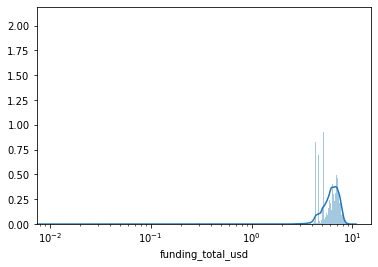

In [73]:
sns.distplot(np.log10(combinedDf[~combinedDf['funding_total_usd'].isna()]['funding_total_usd']),bins=1000,kde=True)
plt.xscale('log')
plt.show()

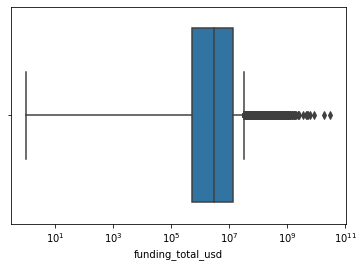

In [75]:
sns.boxplot(combinedDf[~combinedDf['funding_total_usd'].isna()]['funding_total_usd'])
plt.xscale('log')
plt.show()

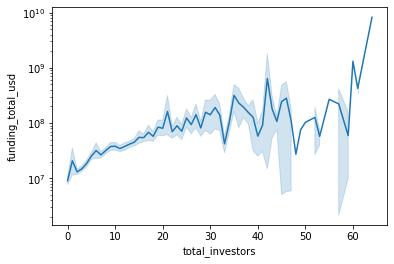

In [81]:
temp = combinedDf[~combinedDf['funding_total_usd'].isna()]
sns.lineplot(x='total_investors', y='funding_total_usd', data=temp)
plt.yscale('log')

In [78]:
temp.describe()

company_state_code  funding_total_usd  funding_rounds  total_investors
count        31429.000000       3.142900e+04    31429.000000     31429.000000
mean            20.827198       2.130179e+07        2.087531         3.398008
std             16.098922       2.212258e+08        1.645302         5.574305
min              0.000000       1.000000e+00        1.000000         0.000000
25%              5.000000       5.094120e+05        1.000000         0.000000
50%             17.000000       3.000000e+06        1.000000         1.000000
75%             36.000000       1.360000e+07        3.000000         4.000000
max             53.000000       3.007950e+10       19.000000        64.000000

In [82]:
combinedDf[combinedDf['funding_total_usd'].isna()]['total_investors'].value_counts()

0.0     2830
1.0     2471
2.0      462
3.0      177
4.0       78
5.0       45
6.0       30
7.0       18
8.0       15
9.0        9
10.0       8
12.0       5
11.0       5
13.0       4
14.0       4
17.0       3
24.0       2
15.0       2
23.0       1
18.0       1
20.0       1
16.0       1
Name: total_investors, dtype: int64

In [106]:
combinedDf['funding_total_usd'] = combinedDf.groupby('total_investors')['funding_total_usd'].transform(lambda x:x.fillna(x.mean()))
combinedDf['funding_total_usd']=np.log10(combinedDf['funding_total_usd'])
combinedDf.head()

company_permalink  ...  pseudoEstd
0          /organization/-qounter  ...       649.0
1  /organization/004-technologies  ...       654.0
2            /organization/0xdata  ...       636.0
3                 /organization/1  ...       618.0
4           /organization/1-4-all  ...       639.0

[5 rows x 12 columns]

In [0]:
combinedDf['first_funding'] = pd.to_datetime(combinedDf.first_funding)

combinedDf['last_funding'] = pd.to_datetime(combinedDf.last_funding)

combinedDf['funding_duration'] = (combinedDf['last_funding']-combinedDf['first_funding']).astype('timedelta64[M]')
combinedDf['pseudoEstd'] = (combinedDf['first_funding']-combinedDf['first_funding'].min()).astype('timedelta64[M]')

In [0]:
combinedDf['success'] = combinedDf['status']
combinedDf.loc[combinedDf['status'] == 'ipo', 'success'] = 1
combinedDf.loc[combinedDf['status'] == 'acquired', 'success'] = 1
combinedDf.loc[combinedDf['status'] == 'operating', 'success'] = 0
combinedDf.loc[combinedDf['status'] == 'closed', 'success'] = 0


In [109]:
combinedDf.head()

company_permalink  company_state_code  ... pseudoEstd success
0          /organization/-qounter                   9  ...      649.0       0
1  /organization/004-technologies                  16  ...      654.0       0
2            /organization/0xdata                   5  ...      636.0       0
3                 /organization/1                   5  ...      618.0       0
4           /organization/1-4-all                  29  ...      639.0       0

[5 rows x 13 columns]

In [110]:
combinedDf.columns

Index(['company_permalink', 'company_state_code', 'company_category_list',
       'founded_at', 'funding_total_usd', 'status', 'first_funding',
       'last_funding', 'funding_rounds', 'total_investors', 'funding_duration',
       'pseudoEstd', 'success'],
      dtype='object')

In [0]:

success0 = combinedDf[combinedDf.success==0]
success1 = combinedDf[combinedDf.success==1]

# upsample minority
success1_upsampled = resample(success1,
replace=True, # sample with replacement
n_samples=len(success0), # match number in majority class
random_state=27)

#combine majority and upsampled minority
upsampled = pd.concat([success0, success1_upsampled])
# check new class counts
upsampled.success.value_counts()
combinedDf = upsampled

In [0]:
features = ['company_state_code', 'funding_total_usd', 'funding_rounds', 'total_investors', 'funding_duration','pseudoEstd']
totalFeatures = combinedDf[features]
labels = combinedDf['success'].astype('int')


In [0]:
X_train, X_test, y_train, y_test = train_test_split(totalFeatures,labels,test_size=0.2,random_state=1)

In [136]:
params = {
    'max_depth':np.arange(3,10),
    'max_features':[0.7,0.8,0.9,1.0],
    'min_samples_leaf':[3,4,5,7,8,9,10]
    #'criterion':['gini','entropy']
}
print("CLASS WEIGHT = NONE")
dtModelCW0 = DecisionTreeClassifier(criterion='gini',class_weight=None,random_state=1)
gridSearchCW0 = GridSearchCV(dtModelCW0, params, cv=5, verbose=1, n_jobs=-1)
gridSearchCW0.fit(X_train, y_train)
print(gridSearchCW0.best_estimator_)
print('\n')
print("CLASS WEIGHT = BALANCED")
dtModelCW1 = DecisionTreeClassifier(criterion='gini',class_weight='balanced',random_state=1)
gridSearchCW1 = GridSearchCV(dtModelCW1, params, cv=5, verbose=1,n_jobs=-1, scoring=make_scorer(f1_score,average='macro'))
gridSearchCW1.fit(X_train, y_train)
print(gridSearchCW1.best_estimator_)


CLASS WEIGHT = NONE
Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 710 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:   47.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=0.7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')


CLASS WEIGHT = BALANCED
Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   51.4s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=9, max_features=0.9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')


[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:   58.6s finished


In [137]:
y_test.value_counts(normalize=True) # baseline accuracy

0    0.508929
1    0.491071
Name: success, dtype: float64

In [138]:
bestModelCW0 = gridSearchCW0.best_estimator_
y_predCW0 = bestModelCW0.predict(X_test)
accuracyCW0 = accuracy_score(y_test,y_predCW0)
print("The accuracy for no balanced case",accuracyCW0)
print("The macro f1 score for no balanced case",f1_score(y_test,y_predCW0,average='macro'))

# bestModelCW1 = gridSearchCW1.best_estimator_
# y_predCW1 = bestModelCW1.predict(X_test)
# accuracyCW1 = accuracy_score(y_test,y_predCW1)
# print("The accuracy for balanced case",accuracyCW1)
# print("The macro f1 score for balanced case",f1_score(y_test,y_predCW1,average='macro'))

The accuracy for no balanced case 0.782759953614225
The macro f1 score for no balanced case 0.7827010307286373
The accuracy for balanced case 0.7867027444916892
The macro f1 score for balanced case 0.7865428681037687


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.565231 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.565231 to fit



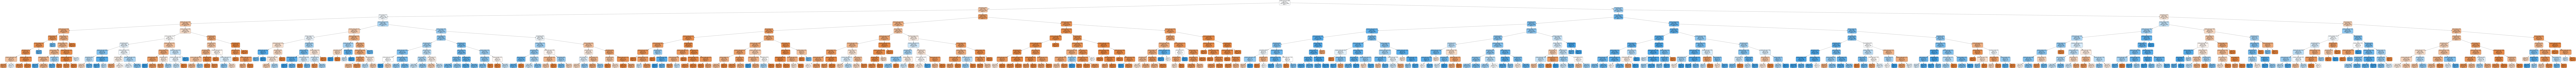

In [139]:
dot_data = StringIO()
export_graphviz(bestModelCW0, out_file=dot_data,filled=True, rounded=True,
                special_characters=True,feature_names = features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('CompanySuccess_dtmodelCW0.png')
Image(graph.create_png())

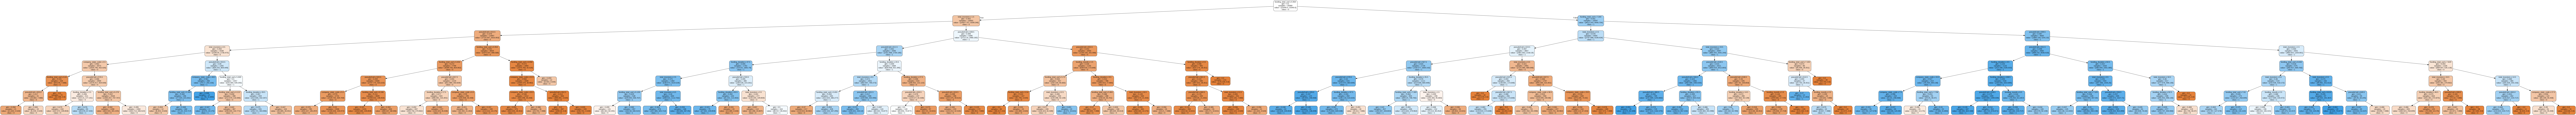

In [126]:
# dot_data = StringIO()
# export_graphviz(bestModelCW1, out_file=dot_data,filled=True, rounded=True,
#                 special_characters=True,feature_names = features,class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png('CompanySuccess_dtmodelCW1.png')
# Image(graph.create_png())

In [150]:
print('\nConfusion matrix for unbalanced class')
print(confusion_matrix(y_test, y_predCW0))

# print('\nConfusion matrix for balanced class')
# print(confusion_matrix(y_test, y_predCW1))



Confusion matrix for unbalanced class
[[4956 1627]
 [1183 5169]]


In [151]:
print('Classification Report for unbalanced class')
reportCW0 = classification_report(y_test,y_predCW0)
print(reportCW0)

# print('Classification Report for balanced class')
# reportCW1 = classification_report(y_test,y_predCW1)
# print(reportCW1)

Classification Report for unbalanced class
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      6583
           1       0.76      0.81      0.79      6352

    accuracy                           0.78     12935
   macro avg       0.78      0.78      0.78     12935
weighted avg       0.78      0.78      0.78     12935



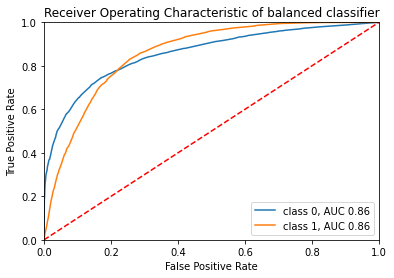

In [152]:
probs = bestModelCW1.predict_proba(X_test)
for i in range(0,2):
    preds = probs[:,i]
    fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=i)
    roc_auc =auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'class {}, AUC {}'.format(i,roc_auc.round(2)))

plt.title('Receiver Operating Characteristic of balanced classifier')    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [145]:
impFeatures = bestModelCW0.feature_importances_
impFeatures

array([0.02355576, 0.37444261, 0.01300938, 0.13034532, 0.06084047,
       0.39780646])

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

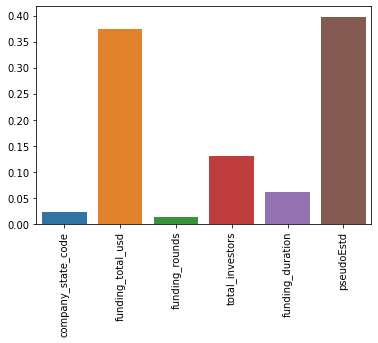

In [149]:
sns.barplot(x=features, y=impFeatures)
plt.xticks(rotation=90)